<a href="https://colab.research.google.com/github/jasreman8/Multi-Agent-System-Projects-II/blob/main/agentic_travel_planner_langgraph_with_deepeval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLS: Multi-Agent Collaboration and Agent Evaluation

# Learning Objectives

- Implement a multi-agent system using `langgraph`, demonstrating multiple design patterns:
  - Supervisor Pattern
  - Reflection Pattern

- Develop test cases and apply metrics — TaskCompletionMetric and ToolCorrectnessMetric — for evaluating the multi-agent system, using the deepeval package.

# Business Case :  Multi-agent Travel Planning System


## Problem Scenario:

Travel planning is a complex and time-consuming process that involves multiple interdependent decisions, such as:
- destination selection,
- itinerary planning, and
- logistics coordination.

Challenges like: i) information overload and ii) budget management are common. Furthermore, personalization and external constraints—such as iii) local weather, iv) communication/language barriers, and v) local holidays/events (specially in international travel) — must also be considered during trip planning.

## Proposed Solution:

The Multi-Agent Travel Planner System, built using LangGraph, offers automated, and personalized travel planning solution. The system utilizes a modular design with *specialized agents & tools for destination suggestion, weather checking, itinerary planning, ticket availability, hotel suggestions, activity recommendations, and external factor analysis (e.g., holidays, language barriers)*. The system utilizes below two multi-agent modular design patterns with specialized agents:

- **Destination Recommender**: Recommends appropriate destinations by leveraging the **Reflection Pattern**. It facilitates iterative conversational interactions between:
  - the Destination-Suggester agent, and
  - the Destination-Reviewer agent in order to suggest an ideal travel destination that suits user preferences.

- **Itinerary Planner**: Drafts a comprehensive travel itinerary by leveraging the **Supervisor Pattern**. Here, the Supervisor manages and orchestrates the work of four specialized agents responsible for:
  - Hotel Recommendation,
  - Local Guide,
  - Trip Planning, and
  - Language Assistance, respectively.

Furthermore, we will assess and evaluate the performance of our multi-agent modules using evaluation metrics - tool call accuracy and goal accuracy.


!pip install -q openai==1.86.0\
            langchain==0.3.24\
            langchain-openai==0.3.14\
            langchain-community==0.3.19\
            langgraph==0.3.34\
            langgraph-supervisor==0.0.18\
            deepeval==2.8.2\
            langchain-tavily==0.2.4\
            pyowm==3.3.0

In [2]:
import os, uuid
from typing import Dict, List, Optional, TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain_community.tools import OpenWeatherMapQueryRun

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END

from langgraph_supervisor import create_supervisor
from langgraph.checkpoint.memory import InMemorySaver
from typing import TypedDict, Optional, Dict, List, Literal
from pydantic import BaseModel, Field
from IPython.display import Image, display


from deepeval.metrics import TaskCompletionMetric, ToolCorrectnessMetric
from deepeval.test_case import LLMTestCase, ToolCall
from deepeval import evaluate

import re, json, random
from datetime import datetime
from google.colab import userdata

In [3]:
# Set environment variables
os.environ["OPENAI_API_KEY"] = userdata.get('OPEN_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('tavily_search_api_key')
os.environ['OPENAI_BASE_URL'] = "https://aibe.mygreatlearning.com/openai/v1"
os.environ["OPENWEATHERMAP_API_KEY"] = userdata.get('openweathermap_api_key')

# llm
openai_api_key = userdata.get('OPEN_API_KEY')

llm = ChatOpenAI(
    api_key=openai_api_key,
    base_url="https://aibe.mygreatlearning.com/openai/v1",
    model='gpt-4o',
    temperature=0
)

# Module 1.Destination Recommender (Reflection Pattern)

## Tools

The built-in TavilySearch tool has been leveraged for web searching, configured to return up to 5 search results with the parameter `include_answer` set to true, enabling direct retrieval of suggested answers without metadata.

In [4]:
# Built-in tools
search = TavilySearch( max_results=5, include_answer=True)

This section defines 5 "tools" used by AI agents:

1. Destination Suggester :
This tool suggests a single travel destination based on user inputs like origin, budget,
interests, trip type, travel dates, and known languages. It ensures previously rejected
destinations are not suggested again.  

2. Weather Checker :
This tool checks historical weather suitability for the specified destination and travel
dates, tailored to the user's interests (e.g., beach activities). It uses TavilySearch to
retrieve weather data and evaluates conditions based on keywords.


3. Ticket Availability Checker :
This tool verifies round-trip direct flight availability between the origin and destination, with ±2-day flexibility. It uses TavilySearch to check flight availability.

4. Language Compatibility Checker :
This tool checks if any of the user's known languages are commonly spoken at the destination. It uses TavilySearch to retrieve language information and returns a JSON object indicating whether the destination is language-compatible.


5. Local Events Checker : This tool checks for major local events at the destination during travel dates that could disrupt travel plans, such as large crowds or peak season events. It uses TavilySearch to retrieve event information and returns a JSON object indicating whether problematic events are found.

### Destination Suggester

In [5]:
class DestinationSuggestion(BaseModel):
    suggested_destination: str
    reason: str
# This class will be a blueprint for the WorkFlow.

In [6]:
@tool
def suggest_destination(origin: str, budget: str, interests: str, trip_type: str,
                      start_date: str, end_date: str, known_languages: List[str],
                      attempts: int, previous_suggestions: List[str]) -> str:
    """Suggest ONE travel destination based on provided user preferences and previous attempts"""
    print(f"\n=== SUGGESTION ATTEMPT #{attempts} ===")
    print(f"Previous rejections: {previous_suggestions}")

    prompt = f"""
    Suggest exactly ONE travel destination based on these requirements:
    - Departing from: {origin}
    - Budget: {budget} USD
    - Travel interests: {interests}
    - Trip type: {trip_type}
    - Travel dates: From {start_date} to {end_date}
    - Known languages: {', '.join(known_languages)}
    - Must NOT suggest any of these: {', '.join(previous_suggestions)}

    Provide a brief explanation why this destination fits the criteria.
    """

    try:
        # Use with_structured_output to enforce JSON format
        result = llm.with_structured_output(DestinationSuggestion).invoke(prompt) # we will only get two values from this invoke

        print(f"[SUGGESTED DESTINATION] {result.suggested_destination}")
        print(f"[SUGGESTION REASON] {result.reason}")

        # Serialize the Pydantic model to a JSON string
        return json.dumps(result.model_dump())

    except Exception as e:
        print(f"Error: {str(e)}")
        # Return a JSON string with the error
        return json.dumps({
            "suggested_destination": "",
            "reason": f"Error occurred: {str(e)}"
        })

### Weather Checker

In [7]:
@tool
def check_historical_weather(destination: str, interests: str, start_date: str, end_date: str) -> str:
    """Check historical weather suitability for travel dates and interests"""
    print(f"\n[ WEATHER CHECK START ]")
    print(f"[ WEATHER CHECK DESTINATION ] -- {destination}")

    # Parse dates to extract month/day ranges
    try:
        start = datetime.strptime(start_date, "%Y-%m-%d")
        end = datetime.strptime(end_date, "%Y-%m-%d")
        if start > end:
            raise ValueError("End date must be on or after start date")
        date_range = f"{start.strftime('%d %B')} to {end.strftime('%d %B %Y')}"
        print(f"[ WEATHER CHECK DURATION ] -- {date_range}")
    except ValueError as e:
        print(f"[ DATE PARSING ERROR ] -- {str(e)}")
        return json.dumps({
            "weather_suitable": False,
            "reason": f"Invalid date format: {str(e)}"
        })

    # Create the search query
    query = f"Historical weather in {destination} from {date_range} for {interests} activities"
    print(f"[ WEATHER CHECK QUERY ] -- {query}")

    # Search weather suitability based on interests
    try:
        # Using Tavily search (preferred since it's already imported and configured)
        results = search.invoke({"query": query})

        # Check if we got an answer in the response
        if 'answer' in results and results['answer']:
            content = results['answer'].lower()
        else:
            # Fallback to using the first result if no direct answer
            if results.get('results') and len(results['results']) > 0:
                content = results['results'][0]['content'].lower()
            else:
                raise ValueError("No weather information found")

        print(f"[ WEATHER DATA FOUND ] -- {content[:200]}...")  # Log first 200 chars

        # Initialize default response
        suitable = True
        reason = "Weather appears suitable for your activities"

        # Activity-specific weather checks
        interests_lower = interests.lower()

        # Beach/mountain specific checks
        if any(word in interests_lower for word in {"beach", "beaches", "mountain", "mountains"}):
            if  "storm" in content :
                suitable = False
                reason = f"Historically  stormy during this period, not ideal for {interests}"
            elif  "freezing" in content or "snow" in content:
                suitable = False
                reason = f"Typically too cold during this time for {interests} activities"

        # Winter sports specific checks
        elif any(word in interests_lower for word in {"skiing", "winter sports", "snowboarding"}):
            if "hot" in content or "melt" in content or "slush" in content:
                suitable = False
                reason = "Typically too warm for good snow conditions"

        # General travel suitability
        if "extreme weather" in content or "severe" in content or "hurricane" in content or "typhoon" in content:
            suitable = False
            reason = "History of extreme weather events during this period"

        print(f"[ WEATHER CHECK IS SUITABLE ] -- {suitable}")
        return json.dumps({
            "weather_suitable": suitable,
            "reason": reason,
            "weather_summary": content[:500]  # Include a snippet of the weather info
        })

    except Exception as e:
        print(f"[ WEATHER CHECK ERROR ] -- {str(e)}")
        return json.dumps({
            "weather_suitable": True,  # Assume suitable if we can't verify
            "reason": f"Could not verify weather conditions: {str(e)}",
            "weather_summary": "Weather information unavailable"
        })

### Ticket Availability Checker

In [8]:
@tool
def check_ticket_availability(origin: str, destination: str, start_date: str, end_date: str) -> str:
    """
    Check round-trip flight availability between origin and destination
    with ±2 day flexibility from given dates. Returns JSON with availability
    and reason.
    """
    # Print header with all parameters
    print(f"\n=== FLIGHT AVAILABILITY CHECK ===")

    # default behaviour
    is_available = True
    reason = "Flights likely available"

    # add keywords indicating no direct flight availability
    no_flight_keywords = ["no flights", "no availability", "no airlines currently offer direct flights" ]

    # Outbound flight check
    print(f"[FLIGHT ROUTE CHECK ] {origin} ↔ {destination}")
    print(f"[TRAVEL DATE ] {start_date}")

    query = f"Are direct flights available from {origin} to {destination} around {start_date} (±2 days)?"
    #result =duckDuckGo_search(query)
    result =search.invoke( {"query" : query})['answer']
    if any(keyword in result.lower() for keyword in no_flight_keywords):
        is_available = False
        reason = "No outbound flights found to destination"
        print("[SEEMS NO OUTBOUND FLIGHTS  AVAILABLE] ")
        return json.dumps({"ticket_availability": is_available, "reason" :reason})

    # inbound flight check
    print(f"[FLIGHT ROUTE CHECK ] {destination} ↔ {origin}")
    print(f"[TRAVEL DATE ] {end_date}")
    query = f"Are direct flights available from {destination}  to {origin} around {end_date} (±2 days)?"
    #result =duckDuckGo_search(query)
    result =search.invoke( {"query" : query})['answer']
    if any(keyword in result.lower() for keyword in no_flight_keywords):
        is_available = False
        reason = "No inbound flights found from destination"
        print("No inbound flights found from destination")
        print("[SEEMS NO INBOUND FLIGHTS AVAILABLE] ")
        return json.dumps({"ticket_availability": is_available, "reason" :reason})

    print("[FLIGHTS LIKELY AVAILABLE] ")
    return json.dumps({"ticket_availability": is_available, "reason" :reason})

### Language Compatibility Checker

In [9]:
@tool
def check_language_compatibility(destination: str, known_languages: List[str]) -> str:
    """Check if any known language is sufficient for communication in the destination"""

    print(f"\n=== LANGUAGE COMPATIBILITY CHECK ===")
    print(f"[CHECKING LANGUAGE COMPATIBILITY IN ] {destination}")
    print(f"[USER LANGUAGES ]: {known_languages}")

    # Search for language information
    query = f"List the commonly spoken Languages in  {destination}"
    result =search.invoke( {"query" : query})['answer']

    if any(language.lower() in result.lower() for language in known_languages):
      print("[LANGUAGE COMPATIBILITY PASS]")
      return json.dumps({"language_compatibility": True})

    else :
      print("[LANGUAGE COMPATIBILITY FAIL]")
      return json.dumps({"language_compatibility": False})

### Local Events Checker

In [10]:
@tool
def check_local_events(destination: str, start_date: str, end_date: str) -> str:
    """Check for major local events during travel dates"""
    print(f"\n=== LOCAL EVENT CHECK ===")
    print(f"[CHECKING FOR ] Events in {destination} between {start_date} and {end_date}")

    # Search for local events
    query= f"Major events in {destination} between {start_date} and {end_date}"
    #results = duckDuckGo_search.run(f"Major events in {destination} between {start_date} and {end_date} ")
    result =search.invoke( {"query" : query})['answer']

    # Keywords that may indicate major local events
    problematic_keywords = ["crowd", "peak season"]

    # Check if any problematic keywords are found in the search results
    is_event = any(keyword in result.lower() for keyword in problematic_keywords)

    print(f"[ LOCAL MAJOR EVENT FOUND ] {'Yes' if is_event else ' No'}")
    # Use json.dumps to return a JSON formatted string
    return json.dumps({
        "local_events": is_event,
    })

## Define State

The below code block defines the state structure for the workflow using Pydantic models.

- The **ReviewOutput** class structures the reviewer's output, indicating whether a destination is approved and provides its feedback.

- The **AgentState** class tracks user inputs, suggested destinations, reviewer feedback, and control flow flags.

In [11]:
# Define reviewer output model
class ReviewOutput(BaseModel):
    """Structured output for the reviewer."""
    approved: bool = Field(..., description="Boolean flag indicating if the destination is approved (True) or rejected(False).")
    destination_feedback: str = Field(..., description="Review of the destination. If not approved, specify reason clearly.")

In [12]:
class AgentState(BaseModel):
    # Initial inputs
    user_input: Dict

    # Iterative fields
    suggested_destination: str = ""
    attempts: int = 0
    reviewer: Optional[str] = None
    structured_reviewer: Optional[ReviewOutput] = None
    previous_suggestions: List[str] = []

    # Control flow flag
    resuggesion_needed: bool = True

    # Final output
    final_destination: str = ""
    error_message: Optional[str] = None

## Agents

This section defines the two AI agents - Destination Suggester and Destination Reviewer, which collaborate to propose and evaluate travel destinations.


1. **Destination Suggester Agent** : This agent uses the `suggest_destination` tool and is responsible for proposing a single destination based on user preferences. It ensures previously rejected destinations are avoided and returns only the destination name.

2. **Destination Reviewer Agent** : This agent evaluates the suggested destination using multiple tools to check weather, flight availability, language compatibility and local events.

The `create_react_agent` function is a convenient way to build agents that can reason about which tools to use and in what sequence to achieve their goals, based on the ReAct prompting framework.

### **Destination-Suggester Agent**

In [13]:
#Primary Agent:  Destination Suggester
destination_suggester = create_react_agent(
    model=llm,
    tools=[suggest_destination],
    prompt = SystemMessage(content="""
    You are a travel destination expert.
    Your goal is to suggest a travel location.
    Input: You will receive the following user details -
    origin, budget, interests, trip type, start date, end date and known languages list.
    You may also receive previouly suggestioned destination.

    Suggest a destination based on the  provided user's preferences.

    Tasks:
        1. Use the  inputs  to understand the user's travel requirements.
        2. Must Use the tool 'suggest_destination' to recommend the best destination based on the user's requirements.
        3. Ensuring not to recommend any destination from the  previous suggestions list

    Output: Provide ONLY the destination name.
"""
)
    )

### Destination-Reviewer Agent

In [14]:
# Reviewer agent : Destination Reviewer
destination_reviewer = create_react_agent(
    model=llm,
    tools=[check_historical_weather, check_ticket_availability,
           check_language_compatibility, check_local_events],
    prompt =SystemMessage(content= """
    You are a meticulous Travel Destination Reviewer.

    Input: You will receive a suggested travel destination including the destination name, origin, budget, interests, travel start and end dates, and a list of known languages.

    Tasks:
    1. Utilize the following tools: 'check_historical_weather', 'check_ticket_availability', 'check_language_compatibility', and 'check_local_events' to evaluate the destination based on the following criteria:
       - Weather suitability for the travel period
       - Availability of direct flights from the origin to destination and back within the specified time frame
       - Language compatibility, ensuring at least one known language is spoken at the destination
       - Absence of major local events that could disrupt travel plans

    2. If any of these criteria are deemed unfavorable, advise against selecting the destination for travel.

    Output: Return a JSON-serialized ReviewOutput object containing the following fields:
    - approved: A boolean indicating if the destination is recommended for travel without foreseeable issues
    - destination_feedback: A concise explanation of why traveling to the destination is advised or not

"""
)
)


## Node Function

The functions defined in this section will become the "nodes" in our LangGraph workflow. Each function takes the current `AgentState` as input and returns a dictionary of updates to that state.

- **Suggester Node** : This function runs the Destination Suggester agent to propose a destination. It validates user inputs, invokes the suggest_destination tool, and updates the state with the new suggestion.

- **Reviewer Node** : This function runs the Destination Reviewer agent to evaluate the suggested destination. It invokes the reviewer agent, parses the output into a structured ReviewOutput object and updates the state with the review results and whether resuggestion is needed.

- **End Node** : This function finalizes the destination by marking the current suggested destination as the final choice and updating the state accordingly.

- **Conditional Node** : This function determines whether to loop back to the suggester node for a new suggestion or proceed to the finalization node based on the reviewer's approval and error state.

### **Suggester Node**

In [15]:
# **Suggester Node**
def run_suggester(state: AgentState) -> AgentState:
    """Runs the destination_suggester agent """

    print("\n=== SUGGESTION PHASE ===")

    print(f"=== SUGGESTION PHASE === (Attempt No #{state.attempts}) ===")

    # Construct input message
    origin = state.user_input.get("origin")
    budget = state.user_input.get("budget")
    interests = state.user_input.get("interests")
    trip_type = state.user_input.get("trip_type")
    start_date = state.user_input.get("start_date")
    end_date = state.user_input.get("end_date")
    known_languages = state.user_input.get("known_languages")

    # Check for missing inputs
    if not (origin and budget and interests and trip_type and start_date and end_date and known_languages):
        return {"error_message": ("Missing initial inputs (Origin, Budget, Interests, "
                                  "Trip Type, Start Date, End Date, Known Languages).")}
    print("=== [USER INPUT] ===")
    print("Origin : " + origin)
    print("Budget : " + budget)
    print("Interests : " + interests)
    print("Trip Type : " + trip_type)
    print("Start Date : " + start_date)
    print("End Date :  " + end_date)
    print("Known Languages : " + str(known_languages))

    # Prepare the previous suggestions list
    previous_suggestions = list(state.previous_suggestions)  # Create a mutable copy
    if state.suggested_destination and state.suggested_destination not in previous_suggestions:
         print(f"Adding '{state.suggested_destination}' to previous suggestions.")
         previous_suggestions.append(state.suggested_destination)

    print("Previous Suggestions " + str(previous_suggestions))

    # Directly invoke the tool with keyword arguments
    try:
        # Pass arguments directly to the tool
        response = suggest_destination.invoke({
            "origin": origin,
            "budget": budget,
            "interests": interests,
            "trip_type": trip_type,
            "start_date": start_date,
            "end_date": end_date,
            "known_languages": known_languages,
            "attempts": state.attempts,
            "previous_suggestions": previous_suggestions
        })

        # The response from the tool is already a JSON string of the suggested destination
        # Parse the JSON string returned by the tool
        result = json.loads(response)

        # Ensure the structure is as expected from the tool's return value
        if "suggested_destination" not in result:
             raise ValueError("Tool response is missing 'suggested_destination' key.")

        print(f"Suggester response: {result}")

        # Update the state
        return {"suggested_destination": result["suggested_destination"],
                "previous_suggestions": previous_suggestions, # Update the state with the new list
                "reviewer": None, # Reset reviewer state
                "structured_reviewer": None, # Reset structured reviewer state
                "resuggesion_needed": True # Assume resuggestion is needed until reviewer says otherwise
               }
    except Exception as e: # Catch the exception as 'e'
        print(f"Suggester Node Error: {e}"); import traceback; traceback.print_exc()
        return {"error_message": f"Suggester step failed: {e}"}


### **Reviewer Node**

In [16]:
def run_reviewer(state: AgentState) -> AgentState:
  """Runs the destination_reviewer agent """

  print("\n=== REVIEW PHASE ===")

  if not state.suggested_destination or state.suggested_destination.startswith("Error"):
     print(" Invalid destination, skipping review")
     return {"error_message": "Missing suggeted destination for review."}

  print(f"Reviewing destination: {state.suggested_destination}")
  # {"messages": [HumanMessage(content=f"Please review the following destination : {destination}")]}
  # input can be given diffrentky as well

  agent_input = {
            "messages": [HumanMessage(content=json.dumps({
                "destination": state.suggested_destination,
                "origin": state.user_input["origin"],
                "budget": state.user_input["budget"],
                "interests": state.user_input["interests"],
                "start_date": state.user_input["start_date"],
                "end_date": state.user_input["end_date"],
                "known_languages": state.user_input["known_languages"]
            }))] }
  try :
    # 1 . Run the reviewer  agent
    response = destination_reviewer.invoke(agent_input)
    review_results = response["messages"][-1].content
    print(f"Review results: {review_results}")

    # 2. Parse the Reviewer's text output using structured output LLM call
    print(f"Review results: {review_results}")
    print("--- Parsing Reviewer Agent output for structured data ---")
    parser_prompt = ChatPromptTemplate.from_messages([
            ("system", """
            Parse the provided text from the destination reviewer.
            Extract the destination feedback (indicated by the word 'destination_feedback') and determine the overall location/destination review.
            Extract the final approval (indicated by the word 'approved').
            Structure the output according to the Review Output schema.
            """),("human", "Reviewer's Text:\n```\n{review_results}\n```") ])
         # Create the parser chain (ensure llm supports structured output)

    parser_chain = parser_prompt | llm.with_structured_output(ReviewOutput)
    structured_review_result: ReviewOutput = parser_chain.invoke({"review_results": review_results})
    print(f"Structured Review Result: {structured_review_result}")

    # 3. Update state
    resuggestion_needed = not structured_review_result.approved
    print(f" Destination needs to be suggested again : {resuggestion_needed}")
    return {
            "reviewer": review_results, # Store raw text for potential use by copywriter
            "structured_reviewer": structured_review_result,
            "resuggesion_needed": resuggestion_needed,
            "attempts" : state.attempts + 1 # Increment the number of attempts
            }
  except Exception as e:
        print(f"Reviewer Node Error (Agent execution or Parsing): {e}"); import traceback; traceback.print_exc()
        return {"error_message": f"Reviewer step failed: {e}"}

### **End Node**

In [17]:
def finalize_destination(state: AgentState) -> AgentState:
  """Marks the current destination as final."""
  print("\n=== FINALIZATION PHASE ===")
  final_destination = state.suggested_destination
  print(f"Final destination: {state.suggested_destination}")
  return {"final_destination" : final_destination}

###  **Conditional Node**

In [18]:
# --- Conditional Edge Logic ---
def make_decision(state: AgentState) :
  """Determines whether to loop back to suggest or finalize """
  print("\n=== DECISION PHASE ===")

  # Access error_message using dot notation, not .get()
  if state.error_message:
        print("Error detected, ending.")
        return END # End immediately if an error occurred in a previous step

  resuggesion_needed = state.resuggesion_needed

  if resuggesion_needed:
        print("Resuggesion needed: Yes, route back to Suggester.")
        return "suggest"
  else:
        print("Resuggesion needed: No, route to Finalize.")
        return "finalize"

## Workflow

 Below section defines the workflow as a StateGraph, adding nodes for suggestion, review and finalization. It sets up edges to control the flow, including a conditional edge after the review node to decide whether to resuggest or finalize.

In [19]:
# Create workflow
workflow = StateGraph(AgentState)
workflow.add_node("suggest", run_suggester)
workflow.add_node("review", run_reviewer)
workflow.add_node("finalize", finalize_destination)

# Define edges
workflow.add_edge(START, "suggest") # Start with the suggester
workflow.add_edge("suggest", "review")

workflow.add_conditional_edges(
    "review",
    make_decision,
    # Map decision outcomes to node names
    {"suggest": "suggest",
     "finalize": "finalize",
     END: END}
)
workflow.add_edge("finalize", END)

workflow.set_entry_point("suggest")

travel_advisor = workflow.compile()

Displaying visual representation of the workflow graph.

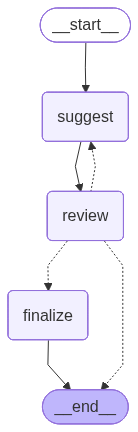

In [20]:
try:
    display(Image(travel_advisor.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("some error")
    pass

## Execution

- Executing the workflow with a sample user input, specifying preferences (origin, travel dates, budget, interests, languages, and trip type).

- Invoking the compiled `travel_advisor` workflow to generate a final destination recommendation.

In [21]:
# Example user input
user_input = {
    "origin": "Chicago",
    "start_date": "2025-12-25",
    "end_date": "2025-12-31",
    "budget": "5000",
    "interests": "beach",
    "known_languages": ["English", "French"],
    "trip_type": "Family"
}
result = travel_advisor.invoke(AgentState(user_input = user_input))


=== SUGGESTION PHASE ===
=== SUGGESTION PHASE === (Attempt No #0) ===
=== [USER INPUT] ===
Origin : Chicago
Budget : 5000
Interests : beach
Trip Type : Family
Start Date : 2025-12-25
End Date :  2025-12-31
Known Languages : ['English', 'French']
Previous Suggestions []

=== SUGGESTION ATTEMPT #0 ===
Previous rejections: []
[SUGGESTED DESTINATION] Cancun, Mexico
[SUGGESTION REASON] Cancun is an ideal destination for a family beach vacation, especially during the winter months when the weather is warm and inviting. Departing from Chicago, you can find direct flights to Cancun, making it a convenient option for families. With a budget of 5000 USD, you can enjoy a comfortable stay at a family-friendly resort, indulge in local cuisine, and participate in various activities such as snorkeling, visiting nearby Mayan ruins, or simply relaxing on the pristine beaches. Cancun is a popular tourist destination where English is widely spoken, and your knowledge of French can be an added advantage 

# Module 2. Itinerary Planner (Supervisor Pattern)

Initialising below, an in-memory saver for conversation state management,  it will allow the system to track session history.

In [22]:
# Initialize memory
memory = InMemorySaver()

## Tools

Two built-in tools will be used in this module:

1. **search_tool**: The Tavily web search tool configured to return up to 5 results. It enables agents to fetch real-time information, such as travel destinations or attraction details, from the internet.
2. **weather_tool**: The Weather Tool sets up the OpenWeatherMapQueryRun tool. It allows agents to retrieve weather forecasts for specific locations.

In [23]:
# Initialize tools
web_search = TavilySearch(max_results=3)
weather_tool = OpenWeatherMapQueryRun()

## Agents

### Hotel Recommender Agent

Defining Hotel Agent that uses web search tool. The agent suggests hotels based on user input(destination, budget, trip type, interests) and returns recommendations directly to the supervisor.

In [24]:
# Hotel Agent
hotel_agent = create_react_agent(
    model=llm,
    tools=[web_search],
    prompt=(
        """
        You are a Hotel Recommendation Agent.
        Your role is to suggest a hotel based on the user’s input, including
         - destination,
         - budget,
         - trip type, and
         - interests.
        Follow these instructions:
        1.You MUST use the web_search tool to find a hotel that aligns with the user’s preferences and budget
        2. Recommend a hotel that align with the user’s preferences and budget, considering proximity to planned activities or attractions if provided."
        3. Do not perform bookings or contact external services.
        4. Submit your results directly to the supervisor.
        """
    ),
    name="Hotel_Agent",
)

### Local Guide Agent

Below code creates a local guide agent with the web search tool. This agent suggests authentic local activities/attractions.

In [25]:
# Local Guide Agent
local_agent = create_react_agent(
    name="Local_Agent",
    model=llm,
    tools=[web_search],
    prompt=(
        """
        You are a Local Guide Agent.
        Your role is to suggest authentic and engaging local activities or places to visit based on the user’s input, including
         - destination,
         - interests,
         - budget, and
         - trip type.
        Follow these instructions:
        1. You MUST use the web_search tool to find activities or attractions that align with the user’s preferences, considering proximity to recommended hotels or the planner’s itinerary if provided.
        2. Ensure suggestions are unique, culturally relevant, or popular with locals, and fit within the budget.
        3. Return your suggestions as a JSON object with fields: activity_name, location, estimated_cost (in USD), description, and why_recommended.
        4. Respond only with the JSON output, without additional text.
        5. Submit your results directly to the supervisor.
        """
    ),
)


### Itinary Planner Agent  

Itinerary Planner Agent is a trip planner agent with web search and weather tools. This agent generates a detailed day-by-day itinerary.

In [26]:
# Planner Agent
planner_agent = create_react_agent(
    name="Planner_Agent",
    model=llm,
    tools=[web_search, weather_tool],
    prompt=(
        """
        You are a Trip Planner Agent.
        Your role is to create a detailed travel itinerary based on the user’s input, including
         - origin,
         - destination,
         - start_date,
         - end_date,
         - budget,
         - interests, and
         - trip type.
        Follow these instructions:
        1. Create a day-by-day itinerary that includes transportation (e.g., flights, local transit), key activities, and estimated costs, ensuring alignment with the user’s budget and interests.
        2. Incorporate hotel recommendations and local activities from other agents if provided, or leave placeholders for them.
        3. Use the 'weather_tool' to retrieve weather data to suggest appropriate activities or packing tips.
        4. Must Use the 'web_search' tool to gather information about transportation options, activities, and costs.
        4. Return your itinerary as a JSON object with fields: day (date), activities (list of {time, description, cost}), transportation, and notes.
        5. Respond only with the JSON output, without additional text.
        6. Submit your results directly to the supervisor.
        """
    ),
)

### Language Assistance Agent

Below code section, creates a language agent with the web search tool. The agent reviews the travel plan for language challenges and provides communication tips based on the user’s known languages.

In [27]:
# Language Agent
language_agent = create_react_agent(
    name="Language_Agent",
    model=llm,
    tools=[web_search],
    prompt=(
        """
        You are a Language Agent.
        Your role is to review the travel plan for the given destination and provide critical tips to address language or communication challenges, considering the user’s known languages.
        Instructions:
        1. You MUST use the web_search tool to validate or gather information about language or communication challenges for the destination.
        2. If the plan includes language tips, validate their adequacy using web_search and provide a rationale.
        3. If no tips are provided, use web_search to suggest 2-3 practical language tips (e.g., key phrases, translation apps, or local communication norms).
        4. Return your feedback as a JSON object with fields: language_tips (list of {tip, description}), is_plan_satisfactory (boolean), and rationale.
        5. Submit your results directly to the supervisor in the structured JSON format.
        """
    ),
)

## Supervisor Workflow

Supervisor is a multi-agent architecture where specialized agents are coordinated by a central supervisor agent. The supervisor agent controls all communication flow and task delegation, making decisions about which agent to invoke based on the current context and task requirements.

Supervisor  coordinate the hotel, planner, local guide, and language agents.It assigns tasks, reviews outputs, integrates results into a cohesive travel plan, and resolves conflicts (if any).

In [28]:
workflow = create_supervisor(
    [planner_agent, hotel_agent, local_agent, language_agent],
    model=llm,
    prompt=(
        """
        You are a supervisor managing a team of four agents: Hotel Recommendation Agent, Trip Planner Agent, Local Guide Agent, and Language Agent.
        Your goal is to coordinate their work to create a detailed, integrated, and cohesive travel plan based on the user’s input, including origin, destination, dates, budget, interests, known languages, and trip type.
        Follow these steps:
        1. Assign tasks to each agent based on their expertise, ensuring all aspects of the user’s request are addressed.
        2. Review each agent’s output for relevance, completeness, and alignment with the user’s preferences and constraints (e.g., budget, interests).
        3. Integrate the outputs into a single, coherent travel plan, resolving any conflicts (e.g., budget overruns or incompatible suggestions).
        4. If an agent’s output is incomplete or irrelevant, re-task them with specific instructions.
        5. Once the plan is complete and incorporates all perspectives, return the final travel plan . When no further tasks remain, respond with 'TERMINATE'.
        Ensure the plan is clear, engaging, and respects the user’s budget and preferences.
        """
    )
)

Compiles the supervisor workflow into an executable form, using the in-memory saver for state persistence.

In [29]:
supervisor_agent_workflow = workflow.compile(checkpointer=memory)

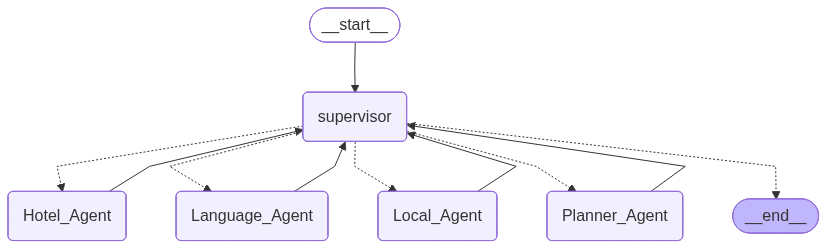

In [30]:
try:
    display(Image(supervisor_agent_workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("some error")
    pass

## Execution

Executing the system with a sample query for a trip to the `Mauritius` (Destination finalised by Module-1).

In [31]:
# User input
destination = 'Cancun'
user_input = {
    "origin": "Chicago",
    "start_date": "2025-12-25",
    "end_date": "2025-12-31",
    "budget": "5000",
    "interests": "beach",
    "known_languages": ["English", "Hindi"],
    "trip_type": "Family"
}

Configuring a session ID and invoking the workflow.

In [32]:
#Execution
user_config = {"configurable": {"thread_id": str(uuid.uuid4())}}
input_message = {"destination": destination, "requirements": user_input}

response = supervisor_agent_workflow.invoke(
        {"messages": [{"role": "user", "content": json.dumps(input_message)}]},
        config=user_config
    )

## Extracts and prints the final response from the supervisor agent, containing the integrated travel plan.
print(response['messages'][-1].content)


Here is your detailed travel plan for a family trip to Cancun from December 25, 2025, to December 31, 2025, with a budget of $5000:

### Travel Itinerary

#### December 25, 2025
- **Morning**: Flight from Chicago to Cancun ($183)
- **Afternoon**: Check-in at Hotel Riu Ventura
- **Evening**: Relax at the hotel and enjoy the amenities

#### December 26, 2025
- **Morning**: Visit Playa Delfines for sunbathing and swimming
- **Afternoon**: Lunch at a local beachside restaurant ($50)
- **Evening**: Explore local shops and markets ($30)

#### December 27, 2025
- **Morning**: Water sports at Playa Tortugas ($100)
- **Afternoon**: Relax at the hotel pool
- **Evening**: Dinner at the hotel's gourmet restaurant ($100)

#### December 28, 2025
- **Morning**: Day trip to Chichén Itzá ($150)
- **Evening**: Return to hotel and relax

#### December 29, 2025
- **Morning**: Visit Isla Mujeres for snorkeling ($120)
- **Afternoon**: Lunch on the island ($60)
- **Evening**: Return to Cancun and enjoy a bea

The conversation history is depicted below. Below code iterates through all messages and shows the interactions between agents.

In [33]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

{"destination": "Cancun", "requirements": {"origin": "Chicago", "start_date": "2025-12-25", "end_date": "2025-12-31", "budget": "5000", "interests": "beach", "known_languages": ["English", "Hindi"], "trip_type": "Family"}}
================================== Ai Message ==================================
Name: supervisor
Tool Calls:
  transfer_to_planner_agent (call_hgmrPeysZTLpU7PZDCu2Fs1K)
 Call ID: call_hgmrPeysZTLpU7PZDCu2Fs1K
  Args:
================================= Tool Message =================================
Name: transfer_to_planner_agent

Successfully transferred to Planner_Agent
================================== Ai Message ==================================
Name: Planner_Agent

```json
[
    {
        "day": "2025-12-25",
        "activities": [
            {
                "time": "Morning",
                "description": "Flight from Chicago to Cancun",
                "cost": 183
         

# Multi-Agent Evaluation

Next, the Multi-Agent Systems will be evaluated by creating test cases, based on the  metrics,
 1. Tool Call Accuracy and
 2. Task Completion Rate.

 The evaluation will be conducted using the `deepeval` package

## Evaluation : Module 1. Destination Recommender (Reflection Pattern)

### Creating Test Cases

The Function `create_test_case_from_query`,

Invokes the agent with the user query to get a response (e.g., suggested destination). It,

- Extracts the final destination from the agent's state or captures errors if invocation fails,
- Infers tool calls from the state (e.g., suggested_destination, reviewer tools) since direct message historyisn't available,
- Converts unhashable lists (e.g., known_languages, previous_suggestions) to tuples to ensure DeepEval can hash the LLMTestCase,
- Constructs tool calls for suggest_destination and reviewer tools (weather, tickets, language, events) with
appropriate input parameters and inferred outputs,
- Returns an LLMTestCase for evaluation with TaskCompletionMetric and ToolCorrectnessMetric.

In [34]:
def create_test_case_from_query(test_query: dict, agent, expected_tools: List[ToolCall]) -> LLMTestCase:
    """
    Runs a query through the travel advisor agent and formats results into a DeepEval LLMTestCase.

    Args:
        test_query: Dictionary with user preferences (origin, budget, etc.).
        agent: Compiled LangGraph travel advisor agent.
        expected_tools: List of expected ToolCall objects.

    Returns:
        LLMTestCase with input, actual output, and tool call details.
    """
    inputs = {"user_input": test_query}
    try:
        response = agent.invoke(inputs)
    except Exception as e:
        return LLMTestCase(
            input=json.dumps(test_query),
            actual_output=f"Error: Agent invocation failed - {str(e)}",
            tools_called=[],
            expected_tools=expected_tools
        )

    actual_output = response.get("final_destination", "No destination selected")
    if response.get("error_message"):
        actual_output = f"Error: {response['error_message']}"

    tools_called_list: List[ToolCall] = []
    if response.get("suggested_destination"):
        input_params = test_query.copy()
        input_params["known_languages"] = tuple(input_params["known_languages"])
        input_params["attempts"] = response.get("attempts", 0)
        input_params["previous_suggestions"] = tuple(response.get("previous_suggestions", []))
        tools_called_list.append(ToolCall(
            name="suggest_destination",
            input_parameters=input_params,
            output=json.dumps({"suggested_destination": response["suggested_destination"], "reason": "Inferred from state"})
        ))

    if response.get("reviewer"):
        reviewer_tools = ["check_historical_weather", "check_ticket_availability",
                         "check_language_compatibility", "check_local_events"]
        for tool_name in reviewer_tools:
            tool_input_params = {
                "destination": response["suggested_destination"],
                "origin": test_query.get("origin"),
                "start_date": test_query.get("start_date"),
                "end_date": test_query.get("end_date"),
                "interests": test_query.get("interests"),
                # to handles hashability issues by converting lists to tuples
                "known_languages": tuple(test_query.get("known_languages", []))
            }
            tools_called_list.append(ToolCall(
                name=tool_name,
                input_parameters=tool_input_params,
                output="Inferred tool call from reviewer execution"
            ))

    return LLMTestCase(
        input=json.dumps(test_query),
        actual_output=actual_output,
        tools_called=tools_called_list,
        expected_tools=expected_tools
    )

# This function prepares the query, agent, and tools for the test case analysis.

Test cases cover diverse preferences (beach, skiing, culture, food/art) to ensure robust evaluation.


In [35]:
# Define test cases
test_query1 = {
    "origin": "London",
    "start_date": "2025-12-25",
    "end_date": "2025-12-31",
    "budget": "5000",
    "interests": "beach",
    "known_languages": ["English", "Hindi"],
    "trip_type": "couple"
}

test_query2 = {
    "origin": "New York",
    "start_date": "2026-07-01",
    "end_date": "2026-07-07",
    "budget": "3000",
    "interests": "skiing",
    "known_languages": ["English"],
    "trip_type": "solo"
}

test_query3 = {
    "origin": "Tokyo",
    "start_date": "2026-09-10",
    "end_date": "2026-09-15",
    "budget": "4000",
    "interests": "culture, history",
    "known_languages": ["English", "Japanese"],
    "trip_type": "family"
}

test_query4 = {
    "origin": "Paris",
    "start_date": "2026-11-01",
    "end_date": "2026-11-08",
    "budget": "6000",
    "interests": "food, art",
    "known_languages": ["French", "English"],
    "trip_type": "group"
}

In [36]:
# Expected tools for each test case
expected_tools1 = [
    ToolCall(name="suggest_destination"),
    ToolCall(name="check_historical_weather"),
    ToolCall(name="check_ticket_availability"),
    ToolCall(name="check_language_compatibility"),
    ToolCall(name="check_local_events")
]


expected_tools2 = expected_tools1  # Same tools expected for skiing query
expected_tools3 = expected_tools1  # Same tools for culture/history query
expected_tools4 = expected_tools1  # Same tools for food/art query

In [37]:
# Generate test cases
test_case1 = create_test_case_from_query(test_query1, travel_advisor, expected_tools1)
test_case2 = create_test_case_from_query(test_query2, travel_advisor, expected_tools2)
test_case3 = create_test_case_from_query(test_query3, travel_advisor, expected_tools3)
test_case4 = create_test_case_from_query(test_query4, travel_advisor, expected_tools4)


=== SUGGESTION PHASE ===
=== SUGGESTION PHASE === (Attempt No #0) ===
=== [USER INPUT] ===
Origin : London
Budget : 5000
Interests : beach
Trip Type : couple
Start Date : 2025-12-25
End Date :  2025-12-31
Known Languages : ['English', 'Hindi']
Previous Suggestions []

=== SUGGESTION ATTEMPT #0 ===
Previous rejections: []
[SUGGESTED DESTINATION] Maldives
[SUGGESTION REASON] The Maldives is an idyllic destination for couples seeking a romantic beach getaway. With its pristine white-sand beaches, crystal-clear turquoise waters, and luxurious overwater bungalows, it offers a perfect setting for relaxation and romance. Departing from London, the Maldives is accessible with a reasonable flight duration, allowing you to maximize your time on the islands. The budget of 5000 USD is sufficient for a week-long stay, including flights, accommodation, and some activities. English is widely spoken in the Maldives, ensuring smooth communication, and the serene environment provides an ideal escape fo

In [38]:
# Combine test cases
test_cases = [test_case1, test_case2, test_case3, test_case4]


### Defining Evaluation Metrics

Two metrics will be used:
 - **TaskCompletionMetric**: Assesses if the recommended destination aligns with user preferences.

- **ToolCorrectnessMetric**: Verifies that the agent uses expected tools (suggest_destination, check_historical_weather,check_ticket_availability, check_language_compatibility, check_local_events) correctly.

In [39]:
# Define evaluation metrics
task_completion_metric = TaskCompletionMetric(
    threshold=0.7,
    model='gpt-4o',
    include_reason=True
)

tool_correctness_metric = ToolCorrectnessMetric()

### Running Evaluations

In [40]:
# Run evaluations
results = evaluate(test_cases=test_cases, metrics=[task_completion_metric, tool_correctness_metric])

✨ You're running DeepEval's latest Task Completion Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Tool Correctness Metric! (using None, strict=False, async_mode=True)...

Evaluating 4 test case(s) in parallel: |██████████|100% (4/4) [Time Taken: 00:06,  1.59s/test case]



Metrics Summary

  - ❌ Task Completion (score: 0.6, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The system provided a destination suggestion and relevant information about Lisbon, which aligns with the user's interest in food and art. However, it did not address the budget constraint or originate the trip from Paris, which are key components of the user's goal., error: None)
  - ✅ Tool Correctness (score: 1.0, threshold: 0.5, strict: False, evaluation model: None, reason: All expected tools ['suggest_destination', 'check_historical_weather', 'check_ticket_availability', 'check_language_compatibility', 'check_local_events'] were called (order not considered)., error: None)

For test case:

  - input: {"origin": "Paris", "start_date": "2026-11-01", "end_date": "2026-11-08", "budget": "6000", "interests": "food, art", "known_languages": ["French", "English"], "trip_type": "group"}
  - actual output: Lisbon, Portugal
  - expected output: None
  - context: None
  - re

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

## Evaluation : Module 2. Itinerary Planner (Supervisor Pattern)

### Creating Test Cases

In [41]:
def create_test_case_from_query(test_query: dict, agent_workflow, expected_tools: List[ToolCall]) -> LLMTestCase:
    """
    Creates a DeepEval LLMTestCase by running a user query through the supervisor_agent_workflow.

    Args:
        test_query: Dictionary with user preferences (e.g., origin, destination, budget, interests, dates, languages, trip_type).
        agent_workflow: Compiled LangGraph supervisor workflow.
        expected_tools: List of expected ToolCall objects (e.g., web_search, weather_tool).

    Returns:
        LLMTestCase with input (serialized query), actual output (itinerary JSON or error), and tool call details.
    """
    user_config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    input_message = {"destination": test_query["destination"], "requirements": test_query}
    inputs = {"messages": [{"role": "user", "content": json.dumps(input_message)}]}

    try:
        response = agent_workflow.invoke(inputs, config=user_config)
    except Exception as e:
        return LLMTestCase(
            input=json.dumps(test_query),
            actual_output=f"Error: Agent invocation failed - {str(e)}",
            tools_called=[],
            expected_tools=expected_tools
        )

    # Extract final itinerary
    final_message = response['messages'][-1].content
    if final_message == "TERMINATE" and len(response['messages']) > 1:
        actual_output = response['messages'][-2].content
    else:
        actual_output = f"Error: Plan generation incomplete - {final_message}"

    tools_called_list: List[ToolCall] = []
    try:
        # Parse itinerary to infer tool usage
        itinerary = json.loads(actual_output) if actual_output.startswith("{") else {}

        # Infer tool calls based on agent outputs
        input_params = test_query.copy()
        input_params["known_languages"] = tuple(input_params["known_languages"])

        # Hotel Agent: web_search
        if "hotel" in itinerary:
            tools_called_list.append(ToolCall(
                name="web_search",
                input_parameters={"query": f"hotels in {test_query['destination']} for {test_query['trip_type']} budget {test_query['budget']}"},
                output=json.dumps({"hotel": itinerary.get("hotel", "Inferred hotel recommendation")})
            ))

        # Local Guide Agent: web_search
        if "activities" in itinerary:
            tools_called_list.append(ToolCall(
                name="web_search",
                input_parameters={"query": f"local activities in {test_query['destination']} for {test_query['interests']}"},
                output=json.dumps({"activities": itinerary.get("activities", "Inferred local activities")})
            ))

        # Planner Agent: web_search and weather_tool
        if "itinerary" in itinerary:
            tools_called_list.append(ToolCall(
                name="web_search",
                input_parameters={"query": f"travel itinerary from {test_query['origin']} to {test_query['destination']} {test_query['start_date']}"},
                output=json.dumps({"itinerary": itinerary.get("itinerary", "Inferred itinerary")})
            ))
            tools_called_list.append(ToolCall(
                name="weather_tool",
                input_parameters={"location": test_query['destination'], "date": test_query['start_date']},
                output="Inferred weather data for itinerary"
            ))

        # Language Agent: web_search
        if "language_tips" in itinerary:
            tools_called_list.append(ToolCall(
                name="web_search",
                input_parameters={"query": f"language tips for {test_query['destination']} known languages {test_query['known_languages']}"},
                output=json.dumps({"language_tips": itinerary.get("language_tips", "Inferred language tips")})
            ))

    except json.JSONDecodeError:
        actual_output = f"Error: Invalid itinerary JSON - {actual_output}"

    return LLMTestCase(
        input=json.dumps(test_query),
        actual_output=actual_output,
        tools_called=tools_called_list,
        expected_tools=expected_tools
    )


In [42]:
test_query1 = {
    "origin": "London",
    "destination": "Maldives",
    "start_date": "2025-12-25",
    "end_date": "2025-12-31",
    "budget": "5000",
    "interests": "beach",
    "known_languages": ["English", "Hindi"],
    "trip_type": "couple"
}

test_query2 = {
    "origin": "New York",
    "destination": "Aspen",
    "start_date": "2026-07-01",
    "end_date": "2026-07-07",
    "budget": "3000",
    "interests": "skiing",
    "known_languages": ["English"],
    "trip_type": "solo"
}

test_query3 = {
    "origin": "Tokyo",
    "destination": "Kyoto",
    "start_date": "2026-09-10",
    "end_date": "2026-09-15",
    "budget": "4000",
    "interests": "culture, history",
    "known_languages": ["English", "Japanese"],
    "trip_type": "family"
}

test_query4 = {
    "origin": "Paris",
    "destination": "Florence",
    "start_date": "2026-11-01",
    "end_date": "2026-11-08",
    "budget": "6000",
    "interests": "food, art",
    "known_languages": ["French", "English"],
    "trip_type": "group"
}

In [43]:
# Expected tools (empty input_parameters to focus on tool names)
expected_tools = [
    ToolCall(name="web_search"),  # Planner Agent
    ToolCall(name="weather_tool"),# Planner Agent
    ToolCall(name="web_search"),  # Hotel Agent
    ToolCall(name="web_search"),  # Local Guide Agent
    ToolCall(name="web_search")   # Language Agent
]



In [44]:
# Generate test cases
test_case1 = create_test_case_from_query(test_query1, supervisor_agent_workflow, expected_tools)
test_case2 = create_test_case_from_query(test_query2, supervisor_agent_workflow, expected_tools)
test_case3 = create_test_case_from_query(test_query3, supervisor_agent_workflow, expected_tools)
test_case4 = create_test_case_from_query(test_query4, supervisor_agent_workflow, expected_tools)

In [45]:
# Combine test cases
test_cases = [test_case1, test_case2, test_case3, test_case4]

### Defining Evaluation Metrics

In [46]:
# Define evaluation metrics
task_completion_metric = TaskCompletionMetric(
    threshold=0.7,
    model='gpt-4o',
    include_reason=True
)

tool_correctness_metric = ToolCorrectnessMetric()

### Running Evaluations

In [47]:
results = evaluate(test_cases=test_cases, metrics=[task_completion_metric, tool_correctness_metric])

✨ You're running DeepEval's latest Task Completion Metric! (using gpt-4o, strict=False, async_mode=True)...

✨ You're running DeepEval's latest Tool Correctness Metric! (using None, strict=False, async_mode=True)...

Evaluating 4 test case(s) in parallel: |██████████|100% (4/4) [Time Taken: 00:04,  1.14s/test case]



Metrics Summary

  - ✅ Task Completion (score: 0.95, threshold: 0.7, strict: False, evaluation model: gpt-4o, reason: The system successfully planned a solo skiing trip to Aspen, considering the user's budget and interest in skiing. It provided a detailed itinerary, including daily activities and accommodation options, all within the specified budget. However, the inclusion of language tips, while useful, was not explicitly requested by the user., error: None)
  - ❌ Tool Correctness (score: 0.0, threshold: 0.5, strict: False, evaluation model: None, reason: Incomplete tool usage: missing tools [ToolCall(
    name="web_search"
), ToolCall(
    name="weather_tool"
)]; expected ['web_search', 'weather_tool', 'web_search', 'web_search', 'web_search'], called []. See more details above., error: None)

For test case:

  - input: {"origin": "New York", "destination": "Aspen", "start_date": "2026-07-01", "end_date": "2026-07-07", "budget": "3000", "interests": "skiing", "known_languages": ["

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.